In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


%matplotlib inline

This is programming assignment for week 5. In this assignment you will be solving classification task. 

### Grading
The assignment contains both automatically graded and peer reviewed tasks. 

**Automatic grading**\
After you finish solving all the tasks restart the kernel (`kernel -> restart`) and and click button `Validate` to check that everything works as expected. Afterwards, you can submit your work.



**Peer Review**\
Some of the tasks cannot be checked automatically,  therefore, we'll be using peer review. Please, download this notebook with solutions (`File → Download as → Notebook (.ipynb)`) and submit it for peer review. Each peer reviewed task contains grading instructions. 



## Part 1. Let's train some decision trees. <a class="anchor" id="part1"></a>

In this part, we will do the simplest preprocessig of the dataset and train decision trees. In the task, you are supposed to predict whether income of a person exceeds \$50K/year. The target variable is equal to `1` if a person earns > \$50k/year and `0` otherwise. 

As an evaluation criterion, we will be using $F_1$score. As you know, it is a weighted average of precision and recall. We are not using accuracy, because the dataset is imbalanced. 

In [30]:
train_data = pd.read_csv('https://github.com/mbburova/MDS/raw/main/week5_train.csv')
train_data.head()

,age,workclass,education,education_years,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,target
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0.0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0.0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0.0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0.0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0.0


In [31]:
from sklearn.model_selection import train_test_split

tr, val = train_test_split(train_data, test_size=0.4, random_state=42)

y_train = tr.target
y_valid = val.target
X_train = tr.drop(['target'], axis=1)
X_valid = val.drop(['target'], axis=1)

<a class="anchor" id="task1"></a>

---
**Task 1** [1 pt] Create `column_transformer` which has the following steps:
- fills all the missing values 
- encodes all the categorical features using OHE 
- scales numerical features.

P.S. note, that you'll have to import all the required modules yourself.

In [32]:
for colname in X_train.select_dtypes(include='object').columns:
    print(f"{colname, X_train[colname].nunique(), *X_train[colname].unique()}\n")

('workclass', 8, 'Private', 'State-gov', 'Self-emp-not-inc', 'Local-gov', nan, 'Self-emp-inc', 'Federal-gov', 'Without-pay', 'Never-worked')

('education', 16, 'Assoc-voc', 'Some-college', 'HS-grad', 'Bachelors', '12th', '7th-8th', 'Masters', 'Assoc-acdm', '10th', '11th', '1st-4th', 'Prof-school', '9th', '5th-6th', 'Doctorate', 'Preschool')

('marital_status', 7, 'Married-civ-spouse', 'Widowed', 'Never-married', 'Divorced', 'Separated', 'Married-spouse-absent', 'Married-AF-spouse')

('occupation', 14, 'Exec-managerial', 'Craft-repair', 'Other-service', 'Transport-moving', 'Sales', 'Prof-specialty', 'Adm-clerical', 'Tech-support', 'Machine-op-inspct', nan, 'Protective-serv', 'Farming-fishing', 'Handlers-cleaners', 'Priv-house-serv', 'Armed-Forces')

('relationship', 6, 'Husband', 'Other-relative', 'Not-in-family', 'Own-child', 'Wife', 'Unmarried')

('race', 5, 'White', 'Black', 'Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Other')

('sex', 2, 'Male', 'Female')

('native_country', 41, 'Un

In [84]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


numerical_features = X_train.select_dtypes(include='number').columns
categorical_features = X_train.select_dtypes(include='object').columns

num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
])

column_transformer = ColumnTransformer([
    ('num', num_pipe, numerical_features), 
    ('cat', cat_pipe, categorical_features)
])


In [85]:
X_transformed = column_transformer.fit_transform(X_train)
print(X_transformed.shape)

X_transformed = column_transformer.fit_transform(X_train)
assert X_transformed.shape[0] == 19536
assert X_transformed.shape[1] == 104

(19536, 104)


<a class="anchor" id="task2"></a>

---
**Task 2** [1 pt] Create a function `tree_pipe`, which given a maximal tree depth returns a pipeline with two steps:

1. Column transformer (defined above)
2. DecisionTreeClassfier with the required `max_depth` parameter

In [70]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

def tree_pipe(max_depth):
    pipeline = make_pipeline(
        column_transformer,
        DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    )
    return pipeline

In [71]:
test_pipe = tree_pipe(1)

test_pipe = tree_pipe(12)
tree = test_pipe.steps[1][1]
assert tree.max_depth == 12

<a class="anchor" id="task3"></a>

---
**Task 3** [Peer Reviewed] Fit decision trees of different depth (from 1 to 100) using the function from the **task 2**. For each depth calculate $F_1$score on the train and validation datasets. Draw a plot, how both scores depend on the maximal tree depth

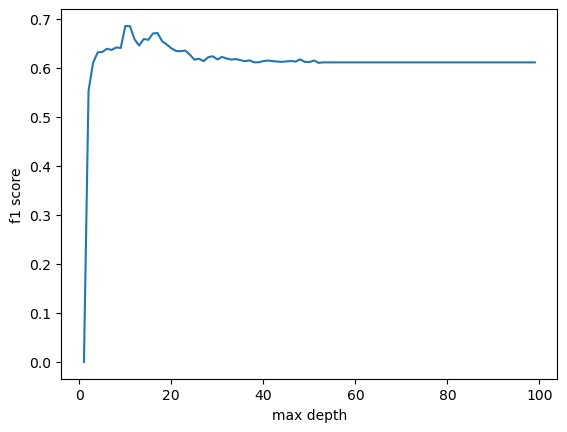

In [49]:
from sklearn.metrics import f1_score

def get_f1_score(max_depth):
    pipeline = tree_pipe(max_depth)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_valid)
    return f1_score(y_valid, y_pred)

depths = np.arange(1, 100)

scores = [get_f1_score(depth) for depth in depths]

plt.plot(depths, scores)
plt.xlabel('max depth')
plt.ylabel('f1 score')
plt.show()
